<a href="https://colab.research.google.com/github/Bibhash123/Resizing_Forensics/blob/main/Validation_Experiments/Proposed_Method_Application_to_UC_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
from google.colab import files
_ = files.upload()
!pip install -q kaggle
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mrutyunjaybiswal/raisetiff-uncompressed-images-dataset-x300
!unzip -q raisetiff-uncompressed-images-dataset-x300.zip -d '/content/RAISE/'
!rm -r raisetiff-uncompressed-images-dataset-x300.zip
clear_output(wait=False)

In [2]:
import os
import numpy as np
import cv2
import glob
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from const import loss_plt

In [3]:
PATH = "/content/RAISE/"
CAND_RF = [0.6, 0.7, 0.8, 0.9, 0.95, 1.05, 1.1, 1.2, 1.3, 1.4]
CROP_SIZE = 256

In [4]:
def extract_images(img,patch_size=256):
    images = []
    for i in range(patch_size,img.shape[0],patch_size):
        for j in range(patch_size,img.shape[1],patch_size):
            images.append(img[i-patch_size:i,j-patch_size:j])
    return images

def crop_img(img):

  img = img[0:CROP_SIZE,0:CROP_SIZE]
  return img

In [5]:
all_files = glob.glob(os.path.join(PATH,"*/*.TIF"))
train_files, val_files = train_test_split(all_files,test_size=0.2,random_state = 101)

def getPatches(files):
  temp = []
  for img in tqdm(files):
    try:
      image = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2GRAY)
      temp.extend(extract_images(image,patch_size=1024))
    except:
      pass
  return temp

images = getPatches(train_files)
test = getPatches(val_files)

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [6]:
# images,test = train_test_split(temp,test_size=0.2, random_state=101, shuffle=True)
# del temp
# _ = gc.collect()

In [7]:
def prepare_data(images,folder,rfs=CAND_RF,return_set = False):
  l = int(len(images)/10)
  to_be_rs = images[:l]
  img_shape = images[0].shape

  resized_images = []
  for img in tqdm(to_be_rs,f"Resizing {l} images with {len(rfs)} candidate factors:"):
    for factor in rfs:
      rs_size = (int(img_shape[0]*factor),int(img_shape[1]*factor))
      rs_img = cv2.resize(img,rs_size,interpolation=cv2.INTER_CUBIC)
      resized_images.append(rs_img)
  
  labels = [[1,0] for i in range(len(images))]+[[0,1] for i in range(len(resized_images))]
  images = images+resized_images

  for id,img in enumerate(tqdm(images,f'Cropping images to size ({CROP_SIZE},{CROP_SIZE}):')):
    images[id] = np.expand_dims(crop_img(img),axis=2)
    np.savez(f'/content/Data/{folder}/img_{id}.npz',images[id],np.array(labels[id]))
  if return_set:
    images,labels = shuffle(images,labels,random_state=101)
    return np.stack(images),np.array(labels)

# X,Y = prepare_data(images)
# del images
!mkdir "/content/Data"
!mkdir "/content/Data/train"
prepare_data(images,"train")
del images

# X_test,Y_test = prepare_data(test)
# del test
!mkdir "/content/Data/val"
X_val,Y_val = prepare_data(test,"val",return_set = True)
del test
_ = gc.collect()
print("final train set size: {}".format(len(os.listdir("/content/Data/train"))))
print("final holdout set size: {}".format(len(os.listdir("/content/Data/val"))))

Resizing 262 images with 10 candidate factors::   0%|          | 0/262 [00:00<?, ?it/s]

Cropping images to size (256,256)::   0%|          | 0/5244 [00:00<?, ?it/s]

Resizing 64 images with 10 candidate factors::   0%|          | 0/64 [00:00<?, ?it/s]

Cropping images to size (256,256)::   0%|          | 0/1284 [00:00<?, ?it/s]

final train set size: 5244
final holdout set size: 1284


In [8]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
class PreprocessLayer(L.Layer):
  def __init__(self,**kwargs):
    super(PreprocessLayer,self).__init__(**kwargs)
  #filter definitions
  #first third and second defined....to define sq and edge
  #elementary filters  
  def a1(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,0,-1,1,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def lin_vertical(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,1,0,0],
                        [0,0,-1,0,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def lin_horizontal(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,1,-1,0,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def a2(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,1,-2,1,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def ord2_vertical(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,1,0,0],
                        [0,0,-2,0,0],
                        [0,0,1,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')

  def a3(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,1,-3,3,-1],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def ord3_horizontal(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [-1,3,-3,1,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def ord3_vertical(self,image):
    filter = K.constant(np.array([[[[0,0,-1,0,0],
                        [0,0,3,0,0],
                        [0,0,-3,0,0],
                        [0,0,1,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')

  #minmax filters
  def b1(self,image):
    return K.minimum(self.a1(image),self.lin_horizontal(image))
  
  def c1(self,image):
    return K.minimum(self.a1(image),self.lin_vertical(image))
  
  def d1(self,image):
    return K.minimum(self.c1(image),self.lin_horizontal(image))
  
  def b2(self,image):
    return K.minimum(self.a2(image),self.ord2_vertical(image))
  
  def b3(self,image):
    return K.minimum(self.a3(image),self.ord3_horizontal(image))
  
  def c3(self,image):
    return K.minimum(self.a3(image),self.ord3_vertical(image))
  
  def d3(self,image):
    return K.minimum(self.c3(image),self.ord3_horizontal(image))
  
  #square filters
  def s3a(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,-1,2,-1,0],
                        [0,2,-4,2,0],
                        [0,-1,2,-1,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def s5a(self,image):
    filter = K.constant(np.array([[[[-1,2,-2,2,-1],
                        [2,-6,8,-6,2],
                        [-2,8,-12,8,-2],
                        [2,-6,8,-6,2],
                        [-1,2,-2,2,-1]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  #edge filters
  def e3_vertical_l(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,-1,2,0,0],
                        [0,2,-4,0,0],
                        [0,-1,2,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e3_horizontal(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [0,2,-4,2,0],
                        [0,-1,2,-1,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')

  def e3_vertical_r(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,2,-1,0],
                        [0,0,-4,2,0],
                        [0,0,2,-1,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e3a(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,-1,2,-1,0],
                        [0,2,-4,2,0],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e3b(self,image):
    return K.minimum(self.e3a(image),self.e3_vertical_l(image))
  
  def e3c(self,image):
    return K.minimum(self.e3a(image),self.e3_horizontal(image))
  
  def e3d(self,image):
    return K.minimum(self.e3c(image),K.minimum(self.e3_vertical_l(image),self.e3_vertical_r(image)))
  
  def e5_vertical_l(self,image):
    filter = K.constant(np.array([[[[-1,2,-2,0,0],
                        [2,-6,8,0,0],
                        [-2,8,-12,0,0],
                        [2,-6,8,0,0],
                        [-1,2,-2,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e5_vertical_r(self,image):
    filter = K.constant(np.array([[[[0,0,-2,2,-1],
                        [0,0,8,-6,2],
                        [0,0,-12,8,-2],
                        [0,0,8,-6,2],
                        [0,0,-2,2,-1]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e5_horizontal(self,image):
    filter = K.constant(np.array([[[[0,0,0,0,0],
                        [0,0,0,0,0],
                        [-2,8,-12,8,-2],
                        [2,-6,8,-6,2],
                        [-1,2,-2,2,-1]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e5a(self,image):
    filter = K.constant(np.array([[[[-1,2,-2,2,-1],
                        [2,-6,8,-6,2],
                        [-2,8,-12,8,-2],
                        [0,0,0,0,0],
                        [0,0,0,0,0]]]]).reshape((5,5,1,1)))
    return K.conv2d(image,filter,padding='same')
  
  def e5b(self,image):
    return K.minimum(self.e5a(image),self.e5_vertical_l(image))
  
  def e5c(self,image):
    return K.minimum(self.e5a(image),self.e5_horizontal(image))
  
  def e5d(self,image):
    return K.minimum(self.e5c(image),K.minimum(self.e5_vertical_l(image),self.e5_vertical_r(image)))

  def call(self,image):
    return K.stack([self.a1(image)[:,:,:,0],
                                self.b1(image)[:,:,:,0],
                                self.c1(image)[:,:,:,0],
                                self.d1(image)[:,:,:,0],
                                self.a2(image)[:,:,:,0],
                                self.b2(image)[:,:,:,0],
                                self.a3(image)[:,:,:,0],
                                self.b3(image)[:,:,:,0],
                                self.c3(image)[:,:,:,0],
                                self.d3(image)[:,:,:,0],
                                self.s3a(image)[:,:,:,0],
                                self.s5a(image)[:,:,:,0],
                                self.e3a(image)[:,:,:,0],
                                self.e3b(image)[:,:,:,0],
                                self.e3c(image)[:,:,:,0],
                                self.e3d(image)[:,:,:,0],
                                self.e5a(image)[:,:,:,0],
                                self.e5b(image)[:,:,:,0],
                                self.e5c(image)[:,:,:,0],
                                self.e5d(image)[:,:,:,0],
                                ],axis=3)
  def get_output_shape(self,input_shape):
    return (input_shape[0],input_shape[1],input_shape[2],20)

In [9]:
class ConvConst(tf.keras.Model):
  def __init__(self,num_classes=10):
    super(ConvConst,self).__init__()
    self.n_classes = num_classes
    self.block1 = PreprocessLayer()
    
    self.block2 = tf.keras.models.Sequential([
                                              L.Conv2D(96,(7,7),strides=2),
                                              L.BatchNormalization(),
                                              L.Activation('tanh'),
                                              L.MaxPool2D(pool_size=(3,3),strides=2)
    ])
    self.block3 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization()
    ])
    self.block4 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('tanh'),
                                             L.MaxPool2D(pool_size=(3,3),strides=2)
    ])
    self.block5 = tf.keras.models.Sequential([
                                             L.Conv2D(128,(1,1),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('tanh'),
                                             L.AveragePooling2D(pool_size=(3,3),strides=2)
    ])

    self.fc1 = L.Dense(200)
    self.fc2 = L.Dense(200)
    self.fc3 = L.Dense(num_classes,activation="softmax")

  def call(self,inputs,**kwargs):
    out = self.block1(inputs)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)

    out = L.Flatten()(out)

    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [16]:
class DataLoader:
  def __init__(self,path):
    self.files = glob.glob(os.path.join(path,"*.npz"))
    self.length = len(self.files)
    np.random.shuffle(self.files)
    self.path = path
  
  def read(self):
    for f in self.files:
      data = np.load(f)
      yield data["arr_0"],list(data["arr_1"])
  
  def batch(self,items,batch_size):
    one_batch = []
    count = 0
    for item in items:
      count+=1
      one_batch.append(item)
      if count%batch_size==0:
        yield one_batch
        one_batch = []
    if len(one_batch)!=0:
      yield one_batch
  
  def flow(self,batch_size):
    while True:
      for bat in self.batch(self.read(),batch_size=batch_size):
        batch_images,batch_labels = [],[]
        for im,label in bat:
          batch_images.append(im)
          batch_labels.append(label)
        yield np.stack(batch_images,axis=0).astype(np.float32),np.stack(batch_labels,axis=0)

In [17]:
train_loader = DataLoader("/content/Data/train")
train = train_loader.flow(batch_size=32)
val_loader = DataLoader("/content/Data/val")
val = train_loader.flow(batch_size=32)

In [18]:
K.clear_session()
model = ConvConst(num_classes=2)
model.compile(loss = 'categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=["accuracy"])
model.build((None,CROP_SIZE,CROP_SIZE,1))

model.layers[0].trainable=False

In [19]:
model.summary()

Model: "conv_const"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess_layer (Preprocess multiple                  0         
_________________________________________________________________
sequential (Sequential)      (None, 62, 62, 96)        94560     
_________________________________________________________________
sequential_1 (Sequential)    (None, 58, 58, 64)        153920    
_________________________________________________________________
sequential_2 (Sequential)    (None, 26, 26, 64)        102720    
_________________________________________________________________
sequential_3 (Sequential)    (None, 12, 12, 128)       8832      
_________________________________________________________________
dense (Dense)                multiple                  3686600   
_________________________________________________________________
dense_1 (Dense)              multiple                  4

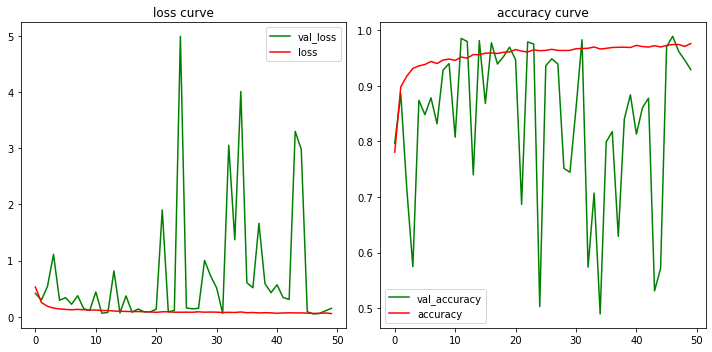

epoch 50/50 loss: 0.058 accuracy: 0.9760 val_loss: 0.151 val_accuracy:0.9291


In [20]:
ckpt = tf.keras.callbacks.ModelCheckpoint("model.hdf5",monitor = "val_accuracy", mode= "max",
                       save_weights_only = True, save_best_only = True)
train_curves = loss_plt()
model.fit(train,
          epochs = 50,
          validation_data = (X_val.astype(np.float32),Y_val),
          steps_per_epoch = train_loader.length//32,
          callbacks = [ckpt,train_curves]
          )


In [22]:
model.load_weights("model.hdf5")
pred = np.argmax(model.predict(X_val.astype(np.float32)),axis=1)
print("Validation Score: {}".format(accuracy_score(np.argmax(Y_val,axis=1),pred)))

Validation Score: 0.9890965732087228
